In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 6 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 6 # fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)


# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Three methods needed to draw those sick angled discs for the EA segments:
def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d = d / sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1,0,0), index)

    normal = normal/(np.dot(normal, normal)) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta

<IPython.core.display.Javascript object>


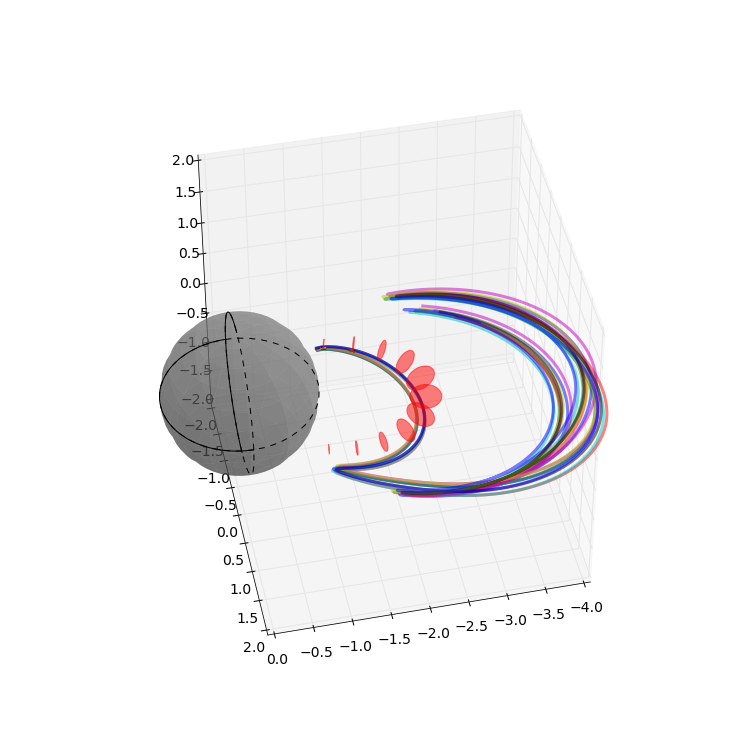

(-2, 2)

In [87]:
import mpl_toolkits.mplot3d.art3d as art3d

from matplotlib.patches import Circle, PathPatch

EA_dump = '/shared/users/asousa/WIPP/3dWIPP/ea_dump.dat'
crossing_log = '/shared/users/asousa/WIPP/3dWIPP/crossing_log.txt'
rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/rayout_damped.ray')
R_E = 6371e3 # Radius of earth in meters


psize = 2
# position in SM, norm in SM, radius
eag = np.loadtxt(EA_dump)
cl  = np.loadtxt(crossing_log)

# fig = plt.figure(figsize=plt.figaspect(0.5)*1.5) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)

fig = plt.figure(figsize=plt.figaspect(1)*1.5)
ax = fig.add_subplot(111, projection='3d')

# Plot the earth
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
elev = 0.0
rot = 0 / 180 * np.pi
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='grey', linewidth=0, alpha=0.5)
a = np.array([-np.sin(elev / 180 * np.pi), 0, np.cos(elev / 180 * np.pi)])
b = np.array([0, 1, 0])
b = b * np.cos(rot) + np.cross(a, b) * np.sin(rot) + a * np.dot(a, b) * (1 - np.cos(rot))
ax.plot(np.sin(u),np.cos(u),0,color='k', linestyle = 'dashed')
horiz_front = np.linspace(0, np.pi, 100)
ax.plot(np.sin(horiz_front),np.cos(horiz_front),0,color='k')
vert_front = np.linspace(np.pi / 2, 3 * np.pi / 2, 100)
ax.plot(a[0] * np.sin(u) + b[0] * np.cos(u), b[1] * np.cos(u), a[2] * np.sin(u) + b[2] * np.cos(u),color='k', linestyle = 'dashed')
ax.plot(a[0] * np.sin(vert_front) + b[0] * np.cos(vert_front), b[1] * np.cos(vert_front), a[2] * np.sin(vert_front) + b[2] * np.cos(vert_front),color='k')


# Plot EA segments
# ax.scatter(eag[:,0], eag[:,1], eag[:,2])
for ea in eag:
#     p = Circle((ea[0], ea[1]), ea[6])
    p = Circle((0,0), ea[6], alpha=0.5, color='r')
    ax.add_patch(p)
#     art3d.pathpatch_2d_to_3d(p, z=ea[2], zdir='z')
    pathpatch_2d_to_3d(p, z=ea[2], normal=[ea[3], ea[4], ea[5]])
    pathpatch_translate(p, (ea[0], ea[1], 0))
    


rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
#     tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
#     tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
#     tmp_coords.convert('MAG','car')
#     tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)

t_cross = [134  ]
# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=3, alpha=0.5)
#     ax.scatter(r.x[t_cross]/R_E, r.y[t_cross]/R_E, r.z[t_cross]/R_E)



# c = cl[0,:]
for c in cl:
    ax.plot([c[0],c[3]], [c[1], c[4]], [c[2], c[5]]);
#     ax.scatter([c[0],c[3]], [c[1], c[4]], [c[2], c[5]]);







# Set size and initial angle
ax.view_init(elev = elev, azim = 75)
ax.set_xlim([-psize*2, 0])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])





In [79]:
ca = 1
cb = 359
dd = 1
D2R = np.pi/180.
R2D = 180./np.pi

np.sin(D2R*ca) - np.sin(D2R*cb) <= np.sin(D2R)


False